**Khai báo thư viện cần sử dụng**

In [1]:
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import shutil
from sklearn.model_selection import train_test_split,StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
import pickle
import cv2

**Fucntion để lấy data từ file âm thanh và nhãn**

In [ ]:

def get_data(name_files,audio,time_limit,sr):

    segment_length = time_limit * sr
    num_segments = (len(audio) // segment_length)
    x = []
    y = []
    for i in range(num_segments):
        start_sample = i * segment_length
        end_sample = (i + 1) * segment_length
        
        segment = audio[start_sample:end_sample]

        create_data(segment,n_fft,n_mels,hop_length)
        
        label = name_files.split('/')[2]
        
        x.append(create_data(segment,n_fft,n_mels,hop_length))

        y.append(label)
    # print(len(x))
    return x,y
def create_data (audio,n_fft,n_mels,hop_length):
    mel_spectrogram = librosa.feature.melspectrogram(y=audio,n_fft= n_fft ,n_mels=n_mels,hop_length=hop_length)
    mel_spectrogram_db = librosa.power_to_db(mel_spectrogram ,ref=np.max)
    mel_spectrogram_db = mel_spectrogram_db + np.abs(np.min(mel_spectrogram_db))
    mel_spectrogram_db= cv2.resize(mel_spectrogram_db,output_size[:2])
    mel_spectrogram_db= np.reshape(mel_spectrogram_db,output_size)
    return mel_spectrogram_db

 **Tham số để để cho quá trình biển đổi , trích xuất âm thanh thô sang mel-spectrogram**

In [18]:
duration = 2
time_limit = duration
sr = 4000
n_fft = 512
n_mels= 128
hop_length = 256
output_size = (64,64,1)

**Lấy data từ file wav có nhãn là Absent**

In [ ]:

x = []
y  = []
x_test = []
x_test =[]
dem = 0

name_files = "C:/Users/duyph/Desktop/heartsound2022/training_data/2530_AV.wav"

audio, sr = librosa.load(name_files, sr=sr,offset = 0)

x,y = get_data(name_files, audio, time_limit = time_limit, sr = sr)

x_test.extend(x)
x_test.extend(y)
print(np.array(x_test).shape)
print(np.array(x_test).shape)

(11, 64, 64, 1)
(11,)


In [ ]:
x_test = np.concatenate([x_test, x_test, x_test], axis=-1)

In [ ]:
print(np.array(x_test).shape)


(11, 64, 64, 3)


90/90 [==============================] - 2s 13ms/step - loss: 0.2671 - accuracy: 0.8678
Loss: 0.26707154512405396
Accuracy: 0.8678261041641235


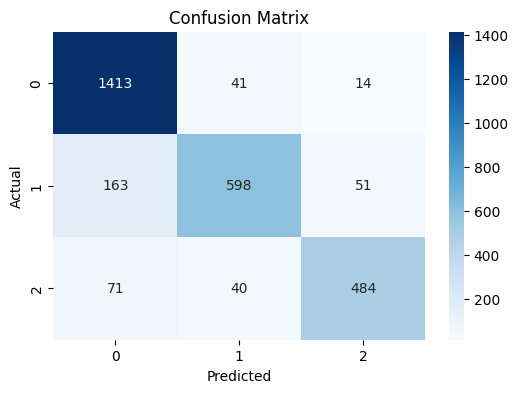

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np


model = load_model('/kaggle/working/best_model_ResNet50.h5') 



predictions = model.predict(x_test)


print(predictions)

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from keras.applications import ResNet50
from keras.optimizers import Adam,Nadam,SGD

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

model = Sequential()
model.add(base_model)
model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))


model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.99), loss='categorical_hinge', metrics=['accuracy'])
# SGD(learning_rate=0.01, momentum=0.9)
#categorical_hinge

#categorical_crossentropy 8.4 - 0.5
model_checkpoint = ModelCheckpoint('/kaggle/working/best_model_ResNet101.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
checkpoint_path = "/kaggle/working/model_checkpoint_{epoch:02d}.h5"

# Tạo callback để lưu model sau mỗi 10 epoch
# checkpoint_callback = ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_accuracy', save_best_only=True, mode='max',
#     save_freq='epoch',
#     period=10  # Lưu model sau mỗi 10 epoch
# )
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_freq=10,  # Lưu mô hình sau mỗi 10 epoch
    save_best_only=True,  # Chỉ lưu mô hình tốt nhất
    monitor='val_accuracy',  # Đánh giá theo dõi để xác định mô hình tốt nhất, có thể là 'val_accuracy' hoặc một đánh giá khác
    mode='max',  # Chế độ 'min' nếu đánh giá giảm là tốt nhất, 'max' nếu đánh giá tăng là tốt nhất
    save_weights_only=False  # Lưu cả kiến trúc và trọng số của mô hình
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 flatten_4 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 24579     
                                                                 
Total params: 23612291 (90.07 MB)
Trainable params: 23559171 (89.87 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
history = model.fit(x_train,y_train,batch_size=256,epochs=200,validation_data=(x_val, y_val),shuffle=True, callbacks=checkpoint_callback)
show_history()

Epoch 1/200
65/65 [==============================] - 26s 181ms/step - loss: 0.6186 - accuracy: 0.6837 - val_loss: 0.8885 - val_accuracy: 0.5486
Epoch 2/200
65/65 [==============================] - 10s 149ms/step - loss: 0.3465 - accuracy: 0.8267 - val_loss: 1.2486 - val_accuracy: 0.3459
Epoch 3/200
65/65 [==============================] - 10s 149ms/step - loss: 0.3243 - accuracy: 0.8381 - val_loss: 0.8955 - val_accuracy: 0.5498
Epoch 4/200
65/65 [==============================] - 10s 149ms/step - loss: 0.3342 - accuracy: 0.8325 - val_loss: 0.9912 - val_accuracy: 0.5030
Epoch 5/200
65/65 [==============================] - 10s 149ms/step - loss: 0.3349 - accuracy: 0.8324 - val_loss: 1.0522 - val_accuracy: 0.4724
Epoch 6/200
65/65 [==============================] - 10s 149ms/step - loss: 0.3213 - accuracy: 0.8391 - val_loss: 0.5239 - val_accuracy: 0.7372
Epoch 7/200
65/65 [==============================] - 10s 149ms/step - loss: 0.3136 - accuracy: 0.8431 - val_loss: 0.3393 - val_accuracy:

In [ ]:
from tensorflow.keras.models import load_model

# Đường dẫn đến các mô hình đã lưu
model_paths = ["model_checkpoint_10.h5", "model_checkpoint_20.h5",
                "model_checkpoint_30.h5", "model_checkpoint_40.h5",
                  "model_checkpoint_50.h5", "model_checkpoint_60.h5",
              "model_checkpoint_70.h5", "model_checkpoint_80.h5",
              "model_checkpoint_90.h5", "model_checkpoint_100.h5",
              "model_checkpoint_110.h5", "model_checkpoint_120.h5",
              "model_checkpoint_130.h5", "model_checkpoint_140.h5",
              "model_checkpoint_150.h5", "model_checkpoint_160.h5",
              "model_checkpoint_170.h5", "model_checkpoint_180.h5",
              "model_checkpoint_190.h5", "model_checkpoint_200.h5"]

# Tính trung bình cộng của các trọng số
avg_weights = None

for model_path in model_paths:
    model = load_model(model_path)
    if avg_weights is None:
        avg_weights = model.get_weights()
    else:
        # Tính trung bình cộng theo từng trọng số
        avg_weights = [avg + weight for avg, weight in zip(avg_weights, model.get_weights())]

# Chia cho số lượng mô hình để có trung bình cộng
avg_weights = [avg / len(model_paths) for avg in avg_weights]

# Tạo mô hình mới với trung bình cộng của các trọng số
avg_model = load_model(model_paths[0])  # Tạo mô hình mới có cấu trúc giống với mô hình đầu tiên
avg_model.set_weights(avg_weights)
avg_model.save("average_model.h5")